In [1]:
!pip install pytrends

  Running setup.py bdist_wheel for pytrends: started
  Running setup.py bdist_wheel for pytrends: finished with status 'done'
  Stored in directory: C:\Users\lunarhero\AppData\Local\pip\Cache\wheels\64\ae\af\51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends


# Section 1: Index Construction
## Step 1: construct static Fears index using the 30 words demonstrated on the paper

In [50]:
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

from wordcloud import WordCloud

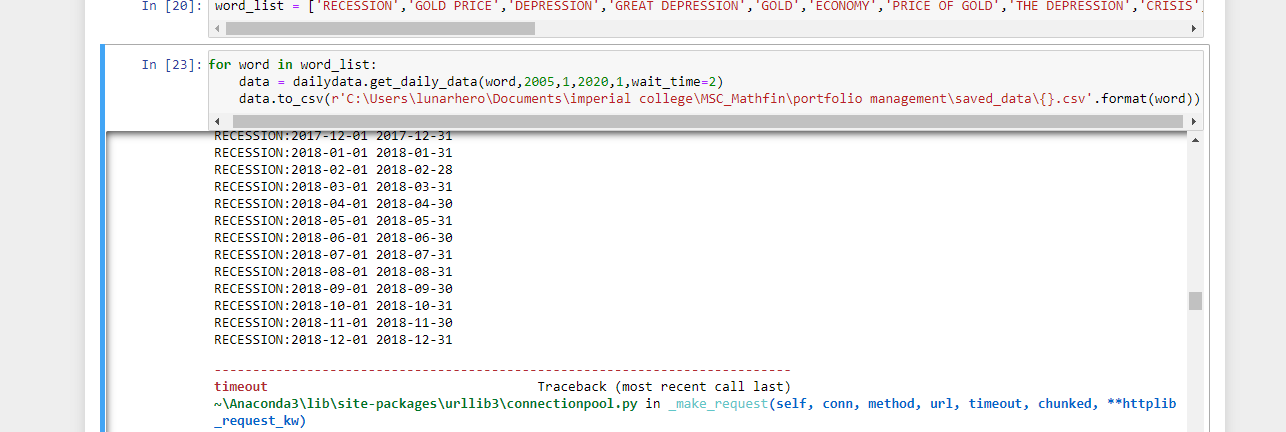

In [ ]:
# from pytrends import dailydata
# word_list = ['GOLD','ECONOMY','PRICE OF GOLD','THE DEPRESSION','CRISIS','FRUGAL','GDP','CHARITY','BANKRUPTCY','UNEMPLOYMENT','INFLATION RATE','BANKRUPT','THE GREAT DEPRESSION','CAR DONATE','CAPITALIZATION','EXPENSE','DONATION','SAVINGS','SOCIAL SECURITY CARD','THE CRISIS','DEFAULT','BENEFITS','UNEMPLOYED','POVERTY','SOCIAL SECURITY OFFICE']
# for word in word_list:
#     from pytrends import dailydata
#     data = dailydata.get_daily_data(word,2005,1,2020,1,wait_time=3)
#     data.to_csv(r'C:\Users\lunarhero\Documents\imperial college\MSC_Mathfin\portfolio management\saved_data\{}.csv'.format(word))

GOLD:2005-01-01 2005-01-31
The request failed: Google returned a response with code 429.
Trying again in 60 seconds.


In [2]:
def update_df2(this_df,df):
    '''
    This function aims to merge two time series into one dataframe
    And it also fill missing dates with extra column
    '''
    try:
        df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
    except:
        try:
            df['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')
        except:
            df['date']=pd.to_datetime(df['date'])
    df=df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)
    #remove the duplicated index
    df = df[~df.index.duplicated()]
    df = df.reindex(idx)
    try:
        df=df.drop(['_id'], axis=1)     
    except:
        pass
    
    # merge two data 
    if len(this_df)==0:
        if len(df)!=0:
            this_df=df
    else:
        this_df=pd.concat([this_df,df],axis=1)
    return this_df

# setup necessaty parameter


idx = pd.date_range('2005-01-01', '2020-01-31')


def load_daily_index(path = 'saved_data/',file_name='daily_trends.csv',force_update=False,debug=False):
    csv_files  = []
    xlsx_files = []

    def action1(cache=[]):
        for r, d, f in os.walk(path):
            for file in f:
                if '.csv' in file:
                    csv_files.append(os.path.join(r, file))
                if '.xlsx' in file:
                    xlsx_files.append(os.path.join(r, file))
        # concate and merge all the dataframes
        for file in csv_files:
            if debug==True:
                print('\r'+file,end='')
            df=pd.read_csv(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)

        for file in xlsx_files:
            df=pd.read_excel(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)
        # save daily data to one csv
        cache.to_csv('merged_data/'+file_name)
        return cache
    
    if force_update == False:
        try:
            this_df = pd.read_csv('merged_data/'+file_name,index_col=0)
        except:
            this_df = action1()
    else:
        this_df = action1()
    return this_df





In [123]:
# this is the 30 words that is shown by the paper
daily_trends=load_daily_index(force_update=False)
daily_trends.index = pd.DatetimeIndex(daily_trends.index)

In [124]:
daily_trends = daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
return_ratio = np.log(daily_trends.iloc[1:,:])-np.log(daily_trends.iloc[:-1,:].values)
for column in list(return_ratio):   
    return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(return_ratio.loc[:,column].values, limits=[0.05, 0.05])

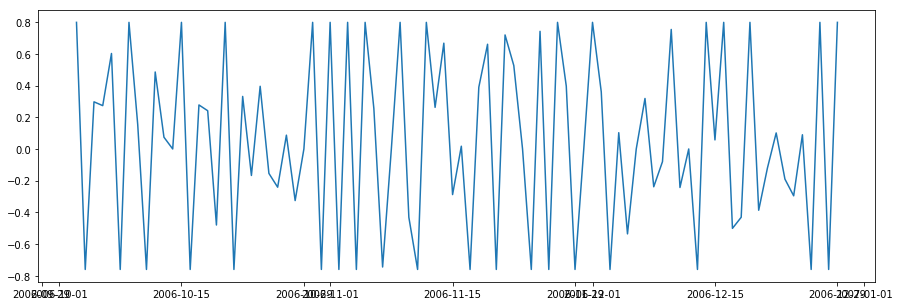

In [125]:
plt.figure(figsize=(15,5))
plt.plot(pd.date_range('2006-10-03','2006-12-29'),return_ratio.loc['2006-10-03':'2006-12-29','PRICE OF GOLD'].values)
plt.show()

### Now remove the seasonality

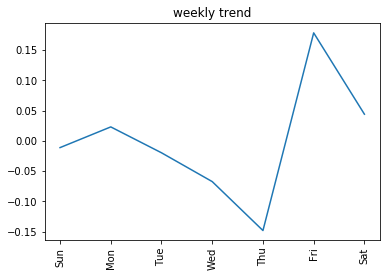

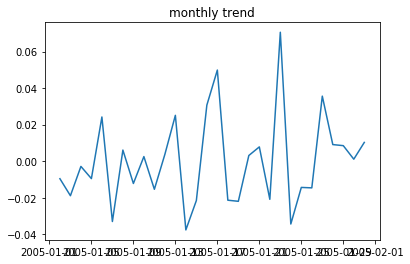

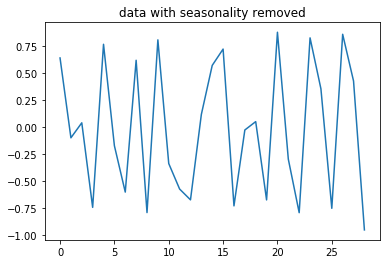

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = return_ratio.loc[:,'PRICE OF GOLD']
weekly = seasonal_decompose(data, freq=7)
plt.plot(weekly.seasonal[3:10])
plt.xticks(weekly.seasonal[3:10].index,['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],rotation='vertical')
plt.title('weekly trend')

plt.show()
data = data - weekly.seasonal
monthly = seasonal_decompose(data, freq=30)
data = data - monthly.seasonal


plt.plot(monthly.seasonal[:30])
plt.title('monthly trend')
plt.show()

plt.plot(data.values[1:30])
plt.title('data with seasonality removed')
plt.show()



def remove_seasonality(data):
    weekly = seasonal_decompose(data, freq=7)
    r = data - weekly.seasonal
    monthly = seasonal_decompose(r, freq=30)
    r = r - monthly.seasonal
    return r

# remove seasonality on weekly and monthly dummy, and standardized by scaling each on standard deviation
original_return = return_ratio.copy()
for column in list(return_ratio):   
    return_ratio.loc[:,column] = remove_seasonality(return_ratio.loc[:,column])
    return_ratio.loc[:,column] /= np.std(return_ratio.loc[:,column].values)

In [156]:
return_ratio['fears_index'] = return_ratio.sum(axis=1)/30
original_return['fears_index'] = original_return.sum(axis=1)/30

#### this is how detrend static index looks like

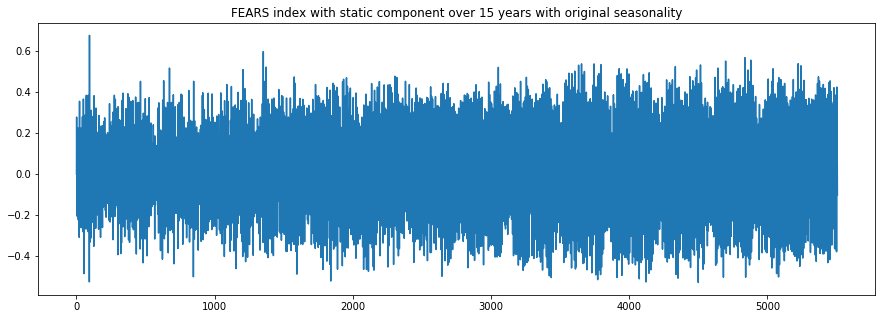

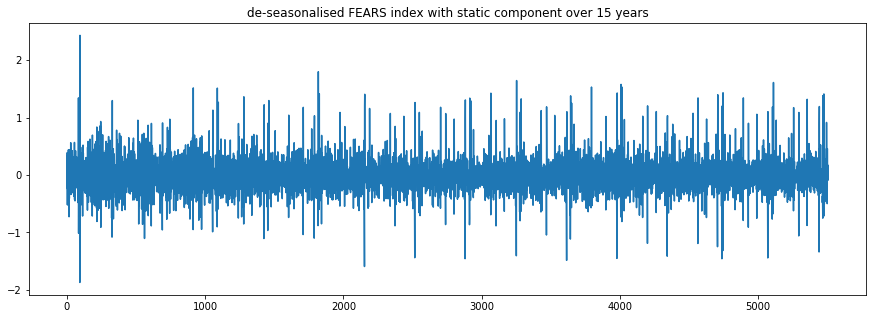

In [8]:
plt.figure(figsize=(15,5))
plt.plot(original_return.fears_index.values)
plt.title('FEARS index with static component over 15 years with original seasonality')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(return_ratio.fears_index.values)
plt.title('de-seasonalised FEARS index with static component over 15 years')
plt.show()


## Step 2: construct all other relevant data:
### including: sp500 EPU,ADS,VIX

In [9]:
SP500=pd.read_csv('merged_data/SP500.csv').iloc[:,[0,4]]
SP500['Date']=pd.to_datetime(SP500['Date'], format='%Y-%m-%d')
SP500=SP500.set_index('Date')
SP500.columns=['SP500']
SP500 = np.log(SP500.iloc[1:,:])-np.log(SP500.iloc[:-1,:].values)


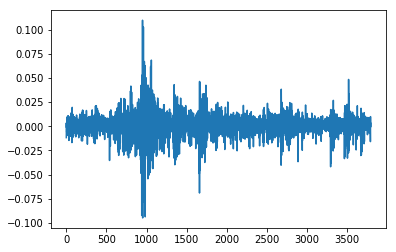

In [192]:
plt.plot(SP500.values)

In [10]:
EPU=pd.read_excel('merged_data/All_Daily_Policy_Data.xlsx')
EPU['Date']=pd.to_datetime(EPU['Date'], format='%d/%m/%Y')
EPU = EPU.set_index('Date')
EPU.columns=['EPU']
EPU = np.log(EPU.iloc[1:,:])-np.log(EPU.iloc[:-1,:].values)


ADS=pd.read_excel('merged_data/ADS_Index_Most_Current_Vintage.xlsx',index_col=0)
ADS.columns=['ADS']
ADS = (ADS.iloc[1:,:]-ADS.iloc[:-1,:].values).divide(ADS.iloc[:-1,:].values)


VIX = pd.read_csv('merged_data/vixcurrent.csv').iloc[:,[0,4]]
VIX['Date']=pd.to_datetime(VIX['Date'], format='%m/%d/%Y')
VIX = VIX.set_index('Date')
VIX.columns=['VIX']
VIX = np.log(VIX.iloc[1:,:])-np.log(VIX.iloc[:-1,:].values)

## Step 3: construct dynamic Fears index selecting from 120 words and with variable updating frequency

### in the paper, the author worked with updating frequency of 6 months, but we could do better than that  :-)
### I put this step here because I need the SP500 data to do regression in order to update FEARS index components.

In [61]:
# first read the data

all_daily_trends = load_daily_index(path = '111_google_trend/',file_name='111_daily_trends.csv', force_update=False,debug=True)
all_daily_trends = all_daily_trends.loc[:,(all_daily_trends.isna().sum()<100).values]  # remove column with too many missing value
select_column = [x for x in list(all_daily_trends) if not '.' in x] #remove duplicates
all_daily_trends = all_daily_trends.loc[:,select_column]  # remove column with too many missing value

In [62]:
all_daily_trends = all_daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
all_return_ratio = np.log(all_daily_trends.iloc[1:,:])-np.log(all_daily_trends.iloc[:-1,:].values)

for column in list(all_return_ratio):              
    # winsorize data
    all_return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(all_return_ratio.loc[:,column].values, limits=[0.05, 0.05])
    # remove seasonality
    all_return_ratio.loc[:,column] = remove_seasonality(all_return_ratio.loc[:,column])
    # removeheteroscedasticity
    all_return_ratio.loc[:,column] /= np.std(all_return_ratio.loc[:,column].values)
all_return_ratio.index = pd.DatetimeIndex(all_return_ratio.index)

In [63]:
def create_dynamic_index(frequency,all_return_ratio,SP500,descending=False):
    '''
    frequency decides the frequency of index updates
    all_return_ratio is the data we want to select from
    SP500 is the index we want to regress on
    descending false represent we select 30 most negatively corrected terms, ascending represents the positive most negative terms
    
    output:
    merged data is the dataset we finally used for the regression
    fre_dictionary saved the frequency of each word to be included into the Fears Index
    '''
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency,unit='M')
    next_end_date = end_date + pd.Timedelta(frequency,unit='M')
    fre_dictionary = {}

    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_SP500 = selected_data.join(SP500,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_SP500.loc[:,[word]])
            model = sm.OLS(selected_data_SP500.loc[:,['SP500']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort(reverse=descending)
            
        negative_30_words = [ranking[i][1] for i in range(30)] 
        for word in negative_30_words:
            if word in fre_dictionary:
                fre_dictionary[word]+=1
            else:
                fre_dictionary[word]=1
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency,unit='M')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    plt.figure(figsize=(15,5))
    plt.plot(Fears_index)
    plt.title('de-seasonalised FEARS index with dynamic component over 15 years')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(return_ratio.fears_index.values)
    plt.title('de-seasonalised FEARS index with static component over 15 years')
    plt.show()
    merged_data= SP500.join(EPU,how='inner')
    merged_data= merged_data.join(ADS,how='inner')
    merged_data= merged_data.join(VIX,how='inner')
    merged_data= merged_data.join(return_ratio.fears_index,how='inner')
    merged_data= merged_data.join(Fears_index,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})

    return merged_data,fre_dictionary

 now end time is 2019-06-16

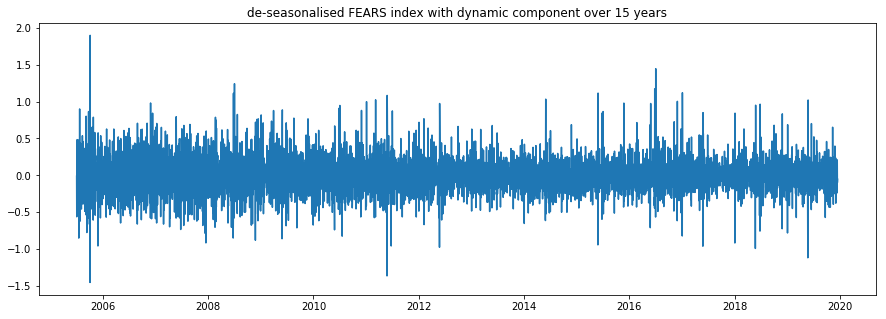

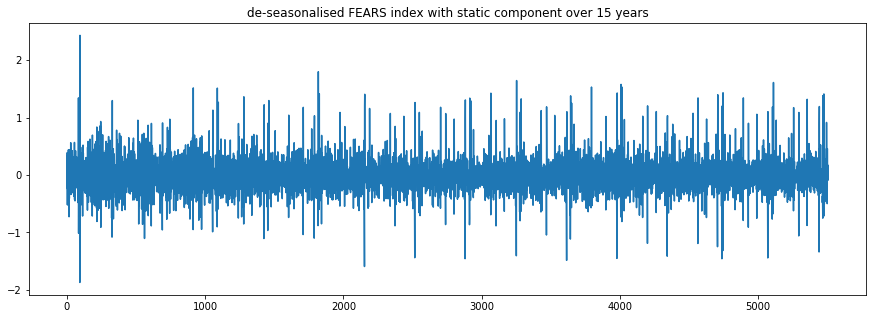

In [64]:
merged_data,word_freq = create_dynamic_index(6, all_return_ratio,SP500)

## Step 4: Check the merged dataset

In [65]:
merged_data.head()

,SP500,EPU,ADS,VIX,static_fears,6month_dynamic_fears
2005-07-05,0.008794,0.668818,-0.144097,0.024265,0.695029,0.450887
2005-07-06,-0.008375,-0.678372,-0.156650,0.049279,-0.270910,-0.357042
2005-07-07,0.002449,0.002929,-0.171888,0.017771,0.077164,0.484266
2005-07-08,0.011611,0.166195,-0.190854,-0.086939,-0.326078,-0.111118
2005-07-11,0.006235,-1.006852,-0.322447,-0.014958,-0.461740,-0.300328


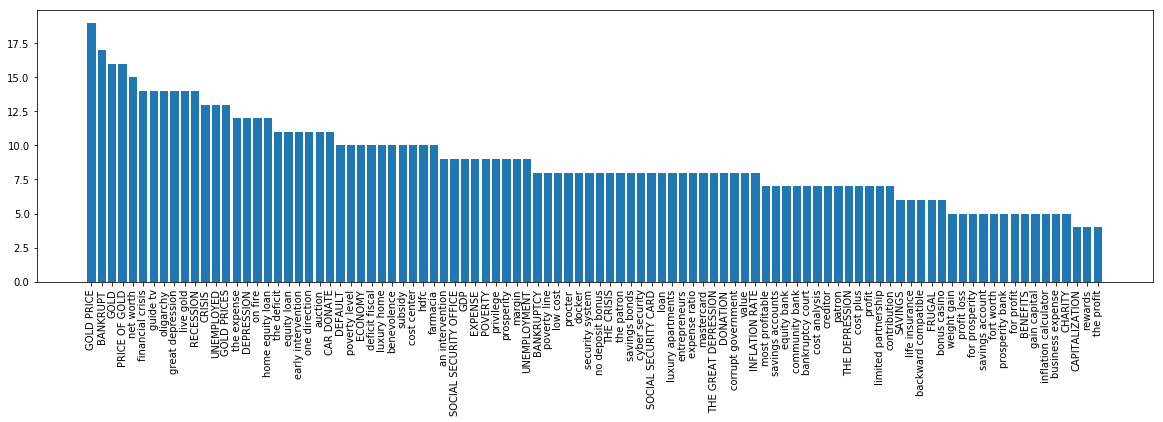

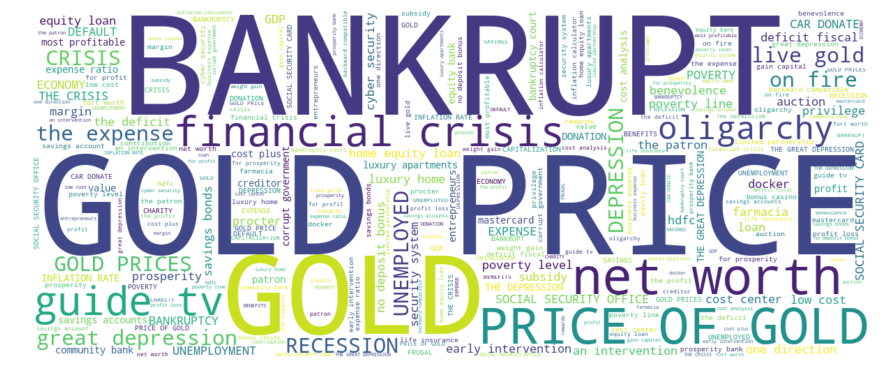

In [69]:
def visualise_frequency(word_freq):
    frequency_ranking = {k: v for k, v in sorted(word_freq.items(), key=lambda item: -item[1])}
    plt.figure(figsize=(20,5))
    plt.bar(range(len(frequency_ranking)), list(frequency_ranking.values()), align='center')
    plt.xticks(range(len(frequency_ranking)), list(frequency_ranking.keys()),rotation='vertical')
    plt.show()
    x, y = np.ogrid[:500, :1200]
    mask = (x - 600) ** 2 + (y - 600) ** 2 > 260 ** 2
    mask = 1200 * mask.astype(int)
    wc = WordCloud(background_color="white", repeat=True, mask=mask).generate_from_frequencies(frequency_ranking)

    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()
    return None
visualise_frequency(word_freq)

# Section 2: fears and average returns

In [31]:
print(len(merged_data))

3638


## Step 1: check relation between return and 6 months fears

### look at the relation between return and FEARS indes as well as some control parameters

In [32]:
def train_ndelay(merged_data,n=1,start = 0, end = 3200-5):
    trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
    if n!=0:
        trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
    
    trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
    trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
    trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
    trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
    trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values
    X = sm.add_constant(trained_data.iloc[:,1:])
    model = sm.OLS(merged_data.iloc[(start+5+n):(end+n),0].values, X).fit()
    print('')
    print('===============================================')
    print('Ret(t+{})'.format(n))
    print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
    print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
    print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])
    print('===============================================')
    print('')
    return None

for n in range(6):
    train_ndelay(merged_data,n)


Ret(t+0)
                          coef       t  P>|t|
const                 0.000300   1.890  0.059
EPU                  -0.000100  -0.514  0.607
ADS                  -0.000300  -1.343  0.180
VIX                  -0.119300 -60.825  0.000
6month_dynamic_fears -0.000071  -0.134  0.894
t-1                  -0.032700  -2.702  0.007
t-2                  -0.018500  -1.523  0.128
t-3                   0.050200   4.131  0.000
t-4                  -0.005000  -0.411  0.681
t-5                  -0.023100  -1.917  0.055
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.545


Ret(t+1)
                          coef      t  P>|t|
const                 0.000300  1.398  0.162
EPU                  -0.000500 -1.254  0.210
ADS                   0.000033  0.107  0.915
VIX                  -0.006200 -1.452  0.147
6month_dynamic_fears  0.001300  1.609  0.108
t                    -0.132100 -5.069  0.000
t-1                  -0.069600 -3.905  0.000
t-2    

## Step 2: contruct FEARS index with componentes weighted averaging

In [162]:
def create_dynamic_index_weighted(frequency,all_return_ratio,SP500,descending=False):
    '''
    frequency decides the frequency of index updates
    all_return_ratio is the data we want to select from
    SP500 is the index we want to regress on
    descending false represent we select 30 most negatively corrected terms, ascending represents the positive most negative terms
    
    output:
    merged data is the dataset we finally used for the regression
    fre_dictionary saved the frequency of each word to be included into the Fears Index
    '''
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency,unit='M')
    next_end_date = end_date + pd.Timedelta(frequency,unit='M')
    historical_select = []
    fre_dictionary = {}
    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_SP500 = selected_data.join(SP500,how='inner')
        ranking = []
        
        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_SP500.loc[:,[word]])
            model = sm.OLS(selected_data_SP500.loc[:,['SP500']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

            
            
            
        # select the 30 most negative words and record number of occurance
        ranking.sort(reverse=descending)
        negative_30_words = [ranking[i][1] for i in range(30)] 
        for word in negative_30_words:
            if word in fre_dictionary:
                fre_dictionary[word]+=1
            else:
                fre_dictionary[word]=1
        
        historical_select.append(negative_30_words)
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency,unit='M')       
        

        
        
    all_return_with_Fears = all_return_ratio.copy()
    #reset start ending date
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency,unit='M')
    next_end_date = end_date + pd.Timedelta(frequency,unit='M')
    i=0
    
    
    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        #calculate the weighted sum
        total_fre = sum([fre_dictionary[word] for word in historical_select[i]])
        list_of_value=[fre_dictionary[word]/total_fre for word in historical_select[i]]
        this_fears_index = selected_data.loc[:,historical_select[i]].dot(list_of_value)
        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency,unit='M')   
        i+=1
        
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    plt.figure(figsize=(15,5))
    plt.plot(Fears_index)
    plt.title('de-seasonalised weighted-averaging FEARS index with dynamic component over 15 years')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(return_ratio.fears_index.values)
    plt.title('de-seasonalised FEARS index with static component over 15 years')
    plt.show()
    merged_data= SP500.join(EPU,how='inner')
    merged_data= merged_data.join(ADS,how='inner')
    merged_data= merged_data.join(VIX,how='inner')
    merged_data= merged_data.join(return_ratio.fears_index,how='inner')
    merged_data= merged_data.join(Fears_index,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
    return merged_data,fre_dictionary

 now end time is 2019-06-16

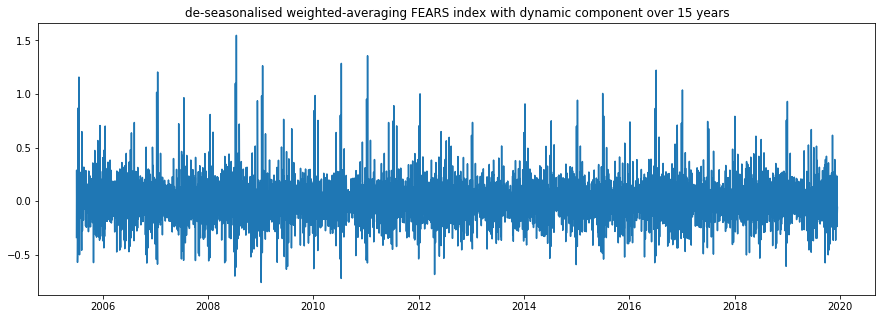

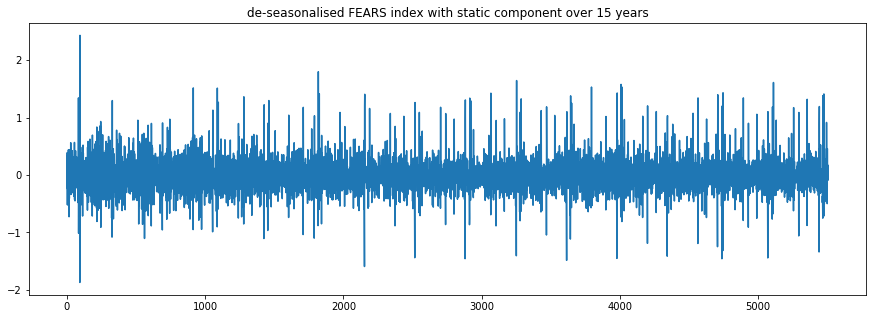

In [163]:
merged_data,word_freq = create_dynamic_index_weighted(6, all_return_ratio, SP500)

In [164]:
for n in range(6):
    train_ndelay(merged_data,n)


Ret(t+0)
                        coef       t  P>|t|
const                 0.0003   1.754  0.080
EPU                  -0.0001  -0.513  0.608
ADS                  -0.0003  -1.365  0.172
VIX                  -0.1193 -60.813  0.000
6month_dynamic_fears  0.0006   0.845  0.398
t-1                  -0.0328  -2.710  0.007
t-2                  -0.0181  -1.493  0.136
t-3                   0.0504   4.150  0.000
t-4                  -0.0051  -0.420  0.674
t-5                  -0.0232  -1.927  0.054
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.545


Ret(t+1)
                         coef      t  P>|t|
const                 0.00030  1.267  0.205
EPU                  -0.00050 -1.292  0.196
ADS                   0.00003  0.098  0.922
VIX                  -0.00620 -1.465  0.143
6month_dynamic_fears  0.00060  0.551  0.582
t                    -0.13240 -5.079  0.000
t-1                  -0.06910 -3.876  0.000
t-2                   0.01910  1.068 

## step3: check result with other frequency

#### 3 month frequency

 now end time is 2019-09-15

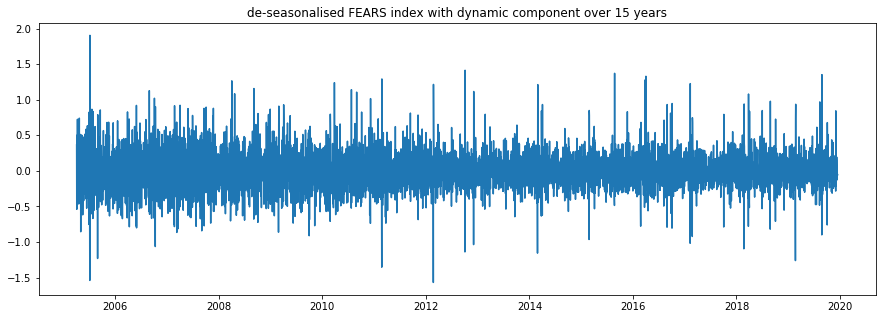

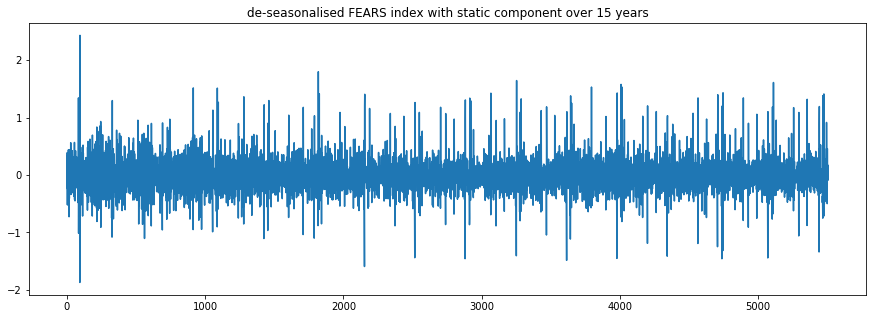

In [70]:
merged_data,word_freq = create_dynamic_index(3, all_return_ratio, SP500)

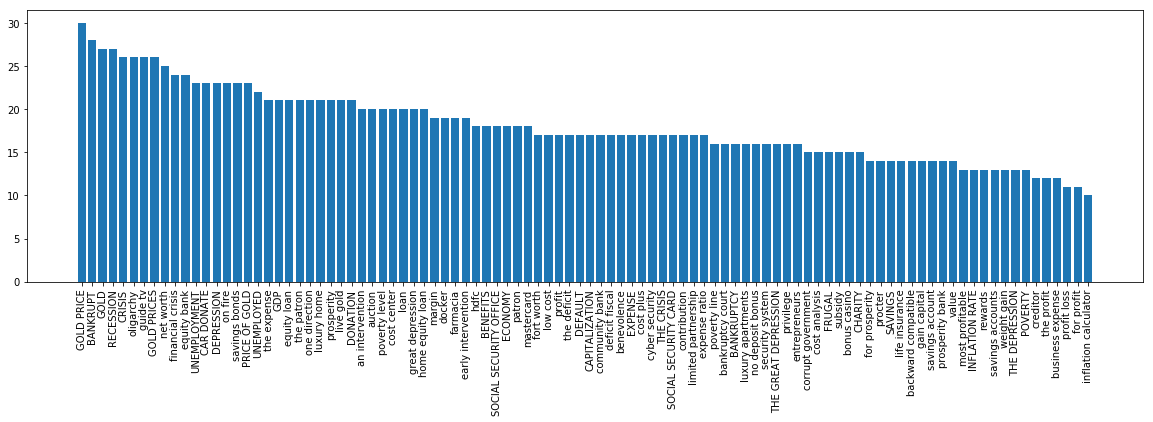

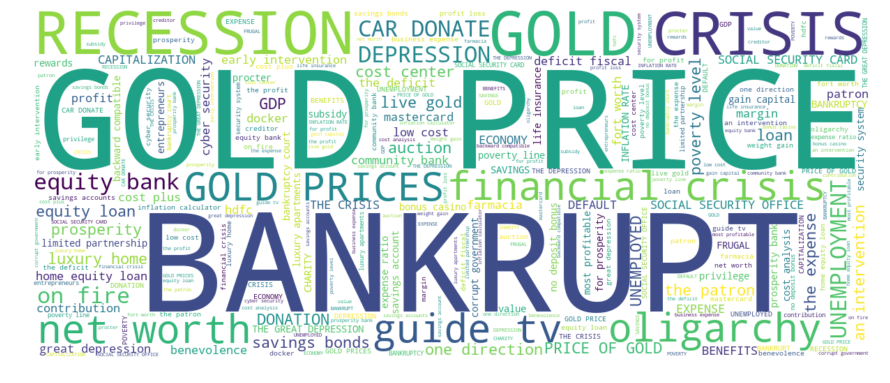

In [71]:
visualise_frequency(word_freq)

In [72]:
for n in range(6):
    train_ndelay(merged_data,n)


Ret(t+0)
                        coef       t  P>|t|
const                 0.0002   1.685  0.092
EPU                  -0.0002  -0.715  0.475
ADS                  -0.0002  -1.075  0.283
VIX                  -0.1226 -61.676  0.000
6month_dynamic_fears -0.0005  -1.105  0.269
t-1                  -0.0330  -2.747  0.006
t-2                  -0.0194  -1.613  0.107
t-3                   0.0500   4.149  0.000
t-4                  -0.0062  -0.519  0.604
t-5                  -0.0226  -1.891  0.059
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.552


Ret(t+1)
                        coef      t  P>|t|
const                 0.0003  1.360  0.174
EPU                  -0.0005 -1.302  0.193
ADS                   0.0001  0.324  0.746
VIX                  -0.0056 -1.278  0.201
6month_dynamic_fears  0.0004  0.496  0.620
t                    -0.1329 -5.060  0.000
t-1                  -0.0661 -3.707  0.000
t-2                   0.0152  0.850  0.395
t-

#### one month frequency

 now end time is 2007-01-22

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

 now end time is 2009-01-11

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

 now end time is 2013-01-20

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

 now end time is 2017-01-29

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

 now end time is 2019-02-18

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
C:\Users\richard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continu

 now end time is 2019-12-15

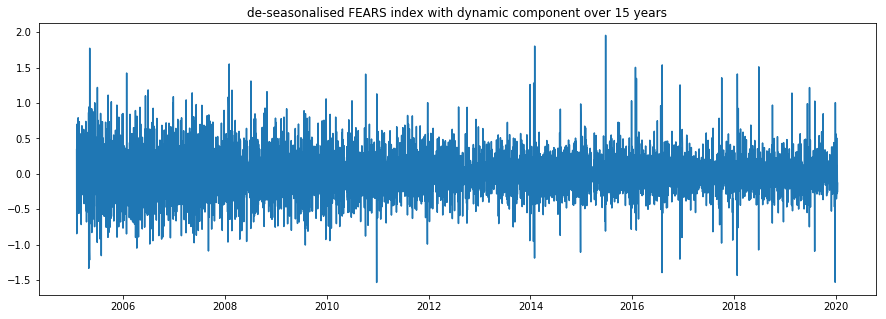

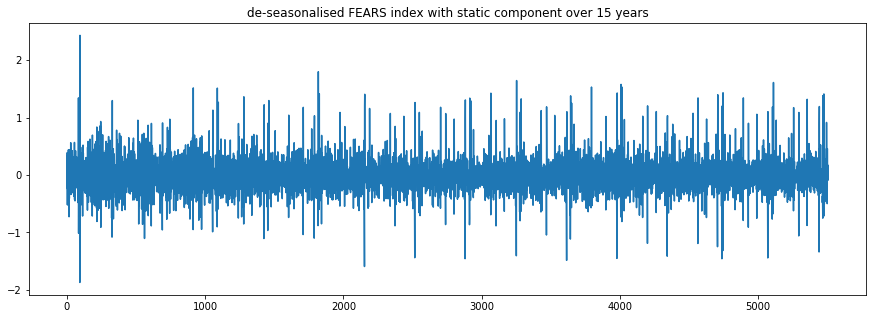

In [73]:
merged_data,word_freq = create_dynamic_index(1, all_return_ratio, SP500)

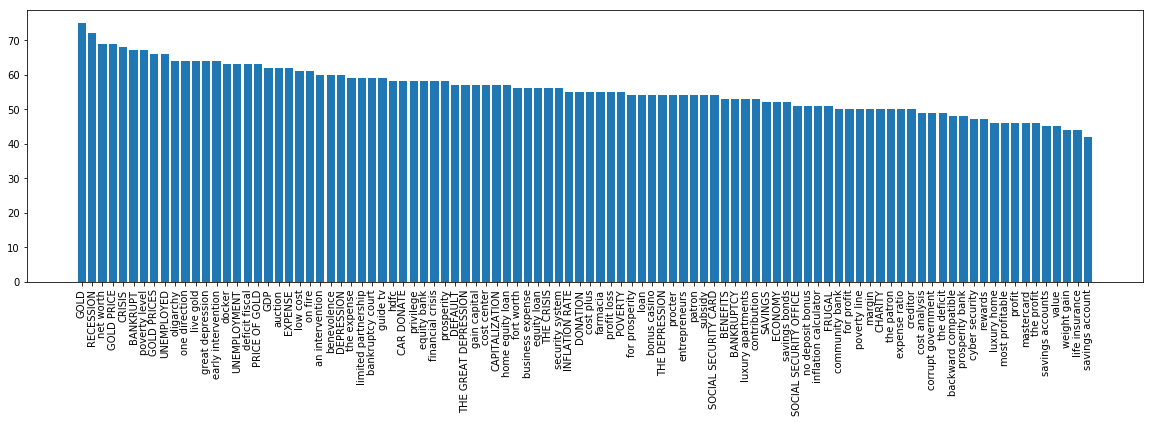

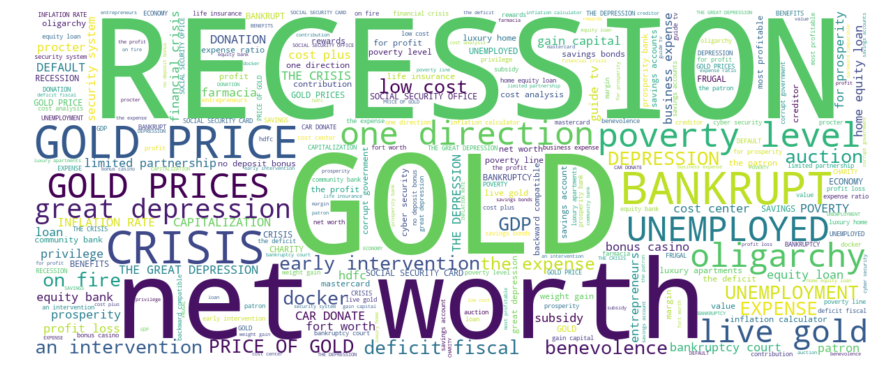

In [74]:
visualise_frequency(word_freq)

In [75]:
for n in range(6):
    train_ndelay(merged_data,n)


Ret(t+0)
                        coef       t  P>|t|
const                 0.0002   1.607  0.108
EPU                  -0.0002  -0.732  0.464
ADS                  -0.0002  -1.069  0.285
VIX                  -0.1232 -61.980  0.000
6month_dynamic_fears -0.0003  -0.783  0.434
t-1                  -0.0322  -2.686  0.007
t-2                  -0.0204  -1.696  0.090
t-3                   0.0502   4.178  0.000
t-4                  -0.0062  -0.514  0.607
t-5                  -0.0229  -1.924  0.054
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.554


Ret(t+1)
                        coef      t  P>|t|
const                 0.0003  1.249  0.212
EPU                  -0.0005 -1.260  0.208
ADS                   0.0001  0.356  0.722
VIX                  -0.0057 -1.303  0.193
6month_dynamic_fears  0.0010  1.582  0.114
t                    -0.1330 -5.049  0.000
t-1                  -0.0670 -3.760  0.000
t-2                   0.0151  0.845  0.398
t-

#### one year frequency

 now end time is 2018-12-30

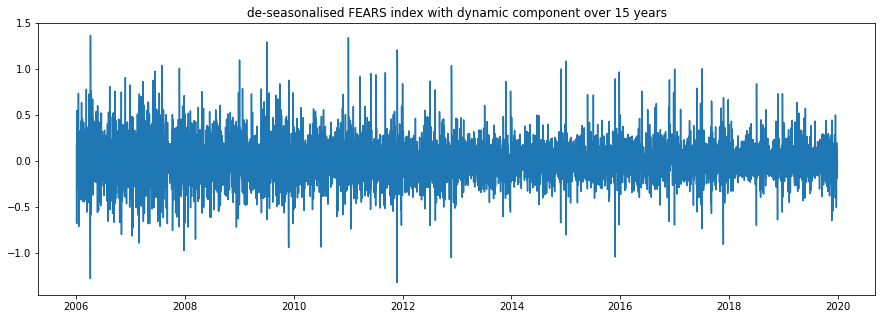

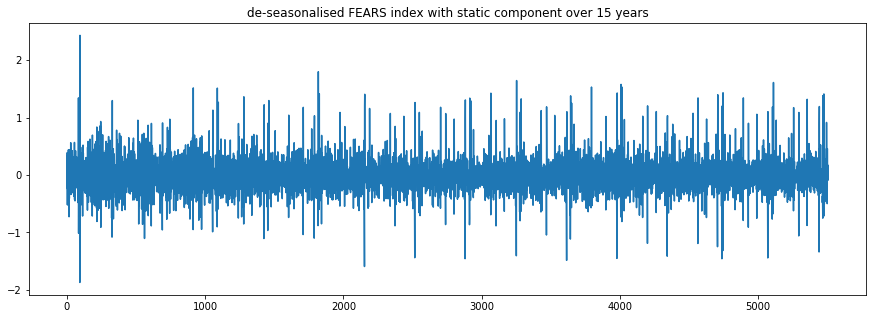

In [97]:
merged_data,word_freq = create_dynamic_index(12, all_return_ratio, SP500)


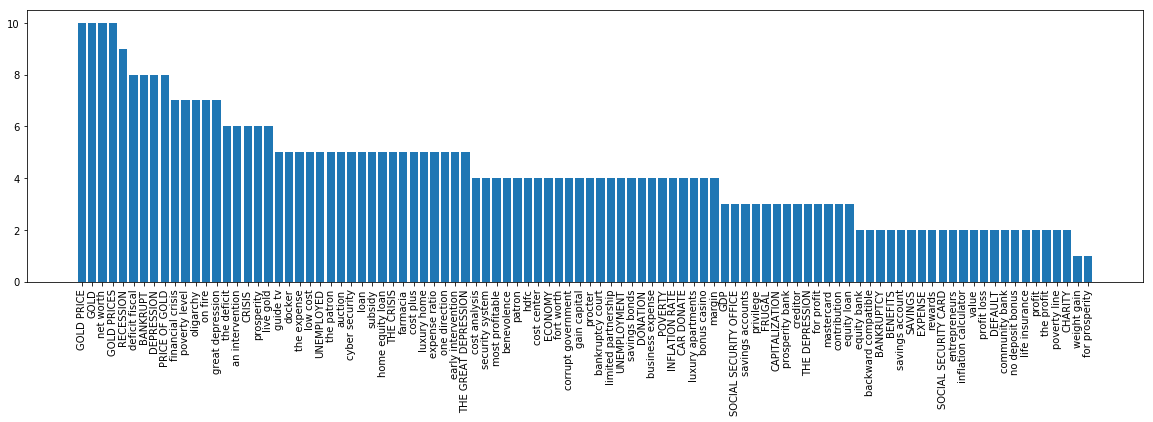

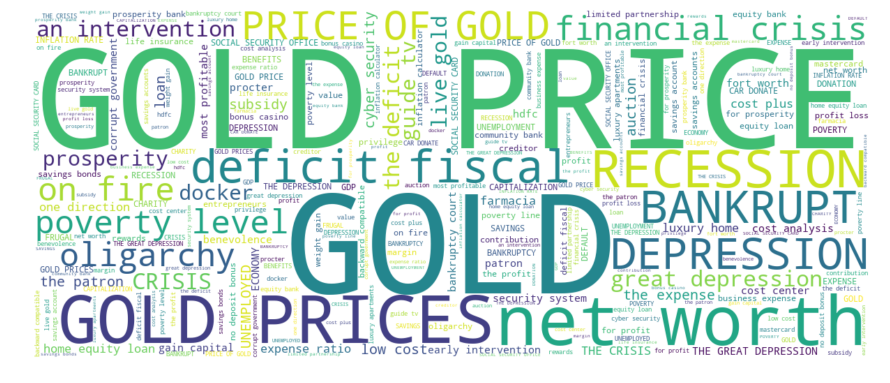

In [98]:
visualise_frequency(word_freq)

In [100]:
for n in range(6):
    train_ndelay(merged_data,n)


Ret(t+0)
                        coef       t  P>|t|
const                 0.0003   1.796  0.073
EPU                  -0.0002  -0.686  0.493
ADS                  -0.0002  -1.397  0.162
VIX                  -0.1181 -60.731  0.000
6month_dynamic_fears -0.0002  -0.318  0.750
t-1                  -0.0338  -2.787  0.005
t-2                  -0.0189  -1.557  0.119
t-3                   0.0507   4.172  0.000
t-4                  -0.0040  -0.333  0.739
t-5                  -0.0233  -1.931  0.054
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.544


Ret(t+1)
                          coef      t  P>|t|
const                 0.000300  1.293  0.196
EPU                  -0.000700 -1.622  0.105
ADS                   0.000019  0.079  0.937
VIX                  -0.005900 -1.399  0.162
6month_dynamic_fears -0.001700 -1.913  0.056
t                    -0.132100 -5.075  0.000
t-1                  -0.068300 -3.835  0.000
t-2                   0.02130